In [1]:
import pandas as pd
import spacy
from joblib import dump, load
from tqdm.notebook import tqdm

# Pipeline, Gridsearch, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# Plot the confusion matrix at the end of the tutorial
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
#Transformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [2]:
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
import numpy as np

In [3]:
%%time
data  = pd.read_excel("./Data/Customer Data.xlsx")

CPU times: total: 781 ms
Wall time: 1.15 s


In [4]:
def quitar_porcentaje_por_clase_y_pais(df, porcentaje, clase, columna_clase, columna_pais):
    # Dividir el DataFrame en dos: uno para la clase específica y otro para las demás clases
    df_clase_especifica = df[df[columna_clase] == clase]
    df_otras_clases = df[df[columna_clase] != clase]
    
    # Función para quitar un porcentaje de filas de un DataFrame
    def quitar_porcentaje_grupo(grupo, porcentaje):
        n = int(len(grupo) * porcentaje / 100)
        return grupo.drop(grupo.sample(n=n).index)
    
    # Aplicar la función a cada grupo de país para la clase específica
    df_clase_reducida = df_clase_especifica.groupby(columna_pais).apply(quitar_porcentaje_grupo, porcentaje=porcentaje).reset_index(drop=True)
    
    # Combinar el DataFrame reducido con el de las otras clases
    df_final = pd.concat([df_clase_reducida, df_otras_clases], axis=0)
    
    return df_final

## 1. Load Data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7077 entries, 0 to 7076
Data columns (total 16 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   Fecha_creación                                         7077 non-null   object
 1   id_Cliente                                             7077 non-null   int64 
 2   Pais                                                   7077 non-null   object
 3   Mensaje                                                7077 non-null   object
 4   Calificacion                                           7077 non-null   object
 5   Canceló la suscripción a las notificaciones de correo  7077 non-null   int64 
 6   Canceló suscripción a todos los correos                7077 non-null   int64 
 7   Correos de marketing entregados                        7077 non-null   int64 
 8   Correos de marketing rebotados                         707

In [6]:
data['Canceló la suscripción a las notificaciones de correo']= [1 if i==True else 0 for i in data['Canceló la suscripción a las notificaciones de correo']]
data['Canceló suscripción a todos los correos'] =[1 if i==True else 0 for i in data['Canceló suscripción a todos los correos']]

In [7]:
data.head()

,Fecha_creación,id_Cliente,Pais,Mensaje,Calificacion,Canceló la suscripción a las notificaciones de correo,Canceló suscripción a todos los correos,Correos de marketing entregados,Correos de marketing rebotados,Correos electrónicos de marketing respondidos,Correos de marketing con clic,Correos de marketing abiertos,Cantidad de Sesiones,Cantidad de Paginas Visitadas,Year,Month
0,2022-03-07,15598251,Peru,formato,No calificado,1,0,7,4,5,1,3,2,2,2022,3
1,2022-04-04,42188351,Chile,3 personas,No calificado,1,0,9,7,4,3,1,7,10,2022,4
2,2022-03-17,54743751,United states,excelente,No calificado,0,0,5,0,2,2,1,4,4,2022,3
3,2022-05-24,72137601,Chile,NECESITO SABER COMO FUNCIONA LA PLATAFORMA GRA...,Calificado,0,0,4,1,1,3,0,3,5,2022,5
4,2022-01-03,73648303,Chile,SOLICITUD DE COTIZACION 2 SUCURSALES.. 90-99 T...,Calificado,1,0,12,3,4,3,4,5,6,2022,1


In [8]:
# data = quitar_porcentaje_por_clase_y_pais(data, 90, "Calificado", 'Calificacion', 'Pais')
# data = data.reset_index(drop=True)

In [9]:
data

,Fecha_creación,id_Cliente,Pais,Mensaje,Calificacion,Canceló la suscripción a las notificaciones de correo,Canceló suscripción a todos los correos,Correos de marketing entregados,Correos de marketing rebotados,Correos electrónicos de marketing respondidos,Correos de marketing con clic,Correos de marketing abiertos,Cantidad de Sesiones,Cantidad de Paginas Visitadas,Year,Month
0,2022-03-07,15598251,Peru,formato,No calificado,1,0,7,4,5,1,3,2,2,2022,3
1,2022-04-04,42188351,Chile,3 personas,No calificado,1,0,9,7,4,3,1,7,10,2022,4
2,2022-03-17,54743751,United states,excelente,No calificado,0,0,5,0,2,2,1,4,4,2022,3
3,2022-05-24,72137601,Chile,NECESITO SABER COMO FUNCIONA LA PLATAFORMA GRA...,Calificado,0,0,4,1,1,3,0,3,5,2022,5
4,2022-01-03,73648303,Chile,SOLICITUD DE COTIZACION 2 SUCURSALES.. 90-99 T...,Calificado,1,0,12,3,4,3,4,5,6,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7072,2023-08-31,319841201,España,-,No calificado,1,0,4,3,0,3,4,1,2,2023,8
7073,2023-08-31,319856251,Mexico,.,No calificado,1,0,4,0,1,2,3,3,6,2023,8
7074,2023-08-31,319910851,Chile,-,No calificado,1,0,5,4,0,1,5,1,1,2023,8
7075,2023-08-31,319961751,Colombia,-,No calificado,1,0,4,0,3,0,2,1,5,2023,8


In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None,train_sizes=np.linspace(.1, 1.0, 5)):
    #Establece el título y etiquetas sus ejes.
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    
    #Métricas parav visualizar la variabilidad del rendimiento a través de las diferentes divisiones de la validación cruzada.
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

## 2. Spacy Stop Word 

In [11]:
#Paquetes para quitar las palabras vacías 
import spacy
from spacy.lang.es.stop_words import STOP_WORDS as SW1
from spacy.lang.pt.stop_words import STOP_WORDS as SW2
from spacy.tokenizer import Tokenizer
import warnings

nlp1 = spacy.load("es_core_news_sm")
nlp2 = spacy.load("pt_core_news_sm")
warnings.filterwarnings('ignore')

In [12]:
def no_s_w(x):
    text=str(x.Mensaje)
    pais=x.Pais
    if pais=='Brazil':
        sw=SW2
    else:
        sw=SW1
    lst=[]
    for token in text.split():
        if token.lower() not in sw:    #checking whether the word is not 
            lst.append(token)   
    return ' '.join(lst)

In [13]:
tqdm.pandas()
data['Mensaje']=data.progress_apply(no_s_w, axis=1)

  0%|          | 0/7077 [00:00<?, ?it/s]

In [14]:
data = data[['Pais','Mensaje','Calificacion']]
data['Calificacion']= [1 if str(i)=='Calificado' else 0 for i in data['Calificacion']]
data = data.dropna()

In [15]:
data.Calificacion.value_counts()

Calificacion
1    3859
0    3218
Name: count, dtype: int64

In [16]:
data

,Pais,Mensaje,Calificacion
0,Peru,formato,0
1,Chile,3 personas,0
2,United states,excelente,0
3,Chile,NECESITO FUNCIONA PLATAFORMA GRACIAS,1
4,Chile,SOLICITUD COTIZACION 2 SUCURSALES.. 90-99 TRAB...,1
...,...,...,...
7072,España,-,0
7073,Mexico,.,0
7074,Chile,-,0
7075,Colombia,-,0


## 3. Modelos De Machine Learning

In [17]:
X= data[['Mensaje','Pais']]
y= data['Calificacion']

### A) CountVectorizer

In [18]:
cat_cols=['Pais']
ct = ColumnTransformer([('count', CountVectorizer(), 'Mensaje' ),
                        ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols)]) #drop='first'

In [19]:
pipe_lr = Pipeline([('column_transformer', ct),
                    ('LR', LogisticRegression())])
pipe_dt = Pipeline([('column_transformer', ct),
                    ('DT',DecisionTreeClassifier())])
pipe_rf = Pipeline([('column_transformer', ct),
                    ('RF',RandomForestClassifier())]) 
pipe_knn = Pipeline([('column_transformer', ct),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('column_transformer', ct),
                     ('SVM', svm.SVC())]) 

In [20]:
#Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=24)

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def fit_evaluate_pipelines(pipelines, X_train, X_test, y_train, y_test):
    # Inicializar un DataFrame vacío para los resultados
    results_df = pd.DataFrame()

    # Diccionario para guardar las matrices de confusión
    confusion_mat_dict = {}

    for name, pipeline in pipelines.items():
        # Entrenar el pipeline
        pipeline.fit(X_train, y_train)
        
        # Realizar predicciones
        y_pred = pipeline.predict(X_test)
        
        # Calcular las métricas de evaluación
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])
        accuracy = accuracy_score(y_test, y_pred)

        # Calcular la matriz de confusión y la especificidad
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn+fp)

        # Guardar la matriz de confusión en el diccionario
        confusion_mat_dict[name] = cm
        
        # Crear un DataFrame temporal para las métricas
        temp_df = pd.DataFrame({
            'Modelo': [f'{name} (Accuracy: {accuracy:.4f})'] * 2,
            'Clasificacion': [0, 1],
            'precision': precision,
            'recall': recall,
            'f1-score': fscore
        })
        
        # Añadir los resultados al DataFrame final
        results_df = pd.concat([results_df, temp_df], ignore_index=True)
        
    # Establecer el índice usando las columnas 'Modelo' y 'Clasificacion'
    results_df.set_index(['Modelo', 'Clasificacion'], inplace=True)
    
    return results_df, confusion_mat_dict

# Definir los pipelines (asegúrate de que están correctamente creados)
pipelines = {
    'Logistic Regression': pipe_lr,
    'Decision Tree': pipe_dt,
    'Random Forest': pipe_rf,
    'KNN': pipe_knn,
    'SVM': pipe_svm
}

# Resultados
results_count, confusion_count = fit_evaluate_pipelines(pipelines, X_train, X_test, y_train, y_test)
results_count

precision  recall  \
Modelo                                 Clasificacion                      
Logistic Regression (Accuracy: 0.9119) 0                   0.88    0.94   
                                       1                   0.95    0.89   
Decision Tree (Accuracy: 0.8966)       0                   0.86    0.93   
                                       1                   0.93    0.87   
Random Forest (Accuracy: 0.9130)       0                   0.89    0.93   
                                       1                   0.94    0.90   
KNN (Accuracy: 0.7458)                 0                   0.65    0.99   
                                       1                   0.98    0.54   
SVM (Accuracy: 0.9260)                 0                   0.90    0.94   
                                       1                   0.95    0.91   

                                                      f1-score  
Modelo                                 Clasificacion            
Logistic Regression (Accuracy: 0.9119) 0                  0.91  
                                       1                  0.92  
Decision Tree (Accuracy: 0.8966)       0                  0.89  
                                       1                  0.90  
Random Forest (Accuracy: 0.9130)       0                  0.91  
                                       1                  0.92  
KNN (Accuracy: 0.7458)                 0                  0.78  
                                       1                  0.69  
SVM (Accuracy: 0.9260)                 0                  0.92  
                                       1                  0.93

In [22]:
# Muestra las matrices de confusión
for model, cm in confusion_count.items():
    print(f"Confusion Matrix for {model}:")
    print(cm)
    print()

Confusion Matrix for Logistic Regression:
[[771  49]
 [107 843]]

Confusion Matrix for Decision Tree:
[[760  60]
 [123 827]]

Confusion Matrix for Random Forest:
[[765  55]
 [ 99 851]]

Confusion Matrix for KNN:
[[810  10]
 [440 510]]

Confusion Matrix for SVM:
[[773  47]
 [ 84 866]]



### B) TfidfVectorizer

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
cat_cols=['Pais']
ct = ColumnTransformer([('tfidf', TfidfVectorizer(), 'Mensaje' ),
                        ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols)]) #drop='first'

In [25]:
pipe_lr = Pipeline([('column_transformer', ct),
                    ('LR', LogisticRegression(class_weight='balanced'))])
pipe_dt = Pipeline([('column_transformer', ct),
                    ('DT',DecisionTreeClassifier(class_weight='balanced'))])
pipe_rf = Pipeline([('column_transformer', ct),
                    ('RF',RandomForestClassifier(class_weight='balanced'))]) 
pipe_knn = Pipeline([('column_transformer', ct),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('column_transformer', ct),
                     ('SVM', svm.SVC(class_weight='balanced'))]) 

In [26]:
# Definir los pipelines (asegúrate de que están correctamente creados)
pipelines = {
    'Logistic Regression': pipe_lr,
    'Decision Tree': pipe_dt,
    'Random Forest': pipe_rf,
    'KNN': pipe_knn,
    'SVM': pipe_svm
}


In [27]:
results_tfidf, confusion_tfidf = fit_evaluate_pipelines(pipelines, X_train, X_test, y_train, y_test)
results_tfidf

precision  recall  \
Modelo                                 Clasificacion                      
Logistic Regression (Accuracy: 0.9136) 0                   0.88    0.94   
                                       1                   0.94    0.89   
Decision Tree (Accuracy: 0.9073)       0                   0.89    0.92   
                                       1                   0.93    0.90   
Random Forest (Accuracy: 0.9186)       0                   0.90    0.93   
                                       1                   0.94    0.91   
KNN (Accuracy: 0.5831)                 0                   0.53    0.97   
                                       1                   0.90    0.25   
SVM (Accuracy: 0.9130)                 0                   0.92    0.89   
                                       1                   0.91    0.93   

                                                      f1-score  
Modelo                                 Clasificacion            
Logistic Regression (Accuracy: 0.9136) 0                  0.91  
                                       1                  0.92  
Decision Tree (Accuracy: 0.9073)       0                  0.90  
                                       1                  0.91  
Random Forest (Accuracy: 0.9186)       0                  0.91  
                                       1                  0.92  
KNN (Accuracy: 0.5831)                 0                  0.68  
                                       1                  0.39  
SVM (Accuracy: 0.9130)                 0                  0.90  
                                       1                  0.92

In [28]:
for model, cm in confusion_tfidf.items():
    print(f"Confusion Matrix for {model}:")
    print(cm)
    print()

Confusion Matrix for Logistic Regression:
[[768  52]
 [101 849]]

Confusion Matrix for Decision Tree:
[[752  68]
 [ 96 854]]

Confusion Matrix for Random Forest:
[[761  59]
 [ 85 865]]

Confusion Matrix for KNN:
[[792  28]
 [710 240]]

Confusion Matrix for SVM:
[[731  89]
 [ 65 885]]



#### *Count VS Tdif*

In [29]:
results_count

precision  recall  \
Modelo                                 Clasificacion                      
Logistic Regression (Accuracy: 0.9119) 0                   0.88    0.94   
                                       1                   0.95    0.89   
Decision Tree (Accuracy: 0.8966)       0                   0.86    0.93   
                                       1                   0.93    0.87   
Random Forest (Accuracy: 0.9130)       0                   0.89    0.93   
                                       1                   0.94    0.90   
KNN (Accuracy: 0.7458)                 0                   0.65    0.99   
                                       1                   0.98    0.54   
SVM (Accuracy: 0.9260)                 0                   0.90    0.94   
                                       1                   0.95    0.91   

                                                      f1-score  
Modelo                                 Clasificacion            
Logistic Regression (Accuracy: 0.9119) 0                  0.91  
                                       1                  0.92  
Decision Tree (Accuracy: 0.8966)       0                  0.89  
                                       1                  0.90  
Random Forest (Accuracy: 0.9130)       0                  0.91  
                                       1                  0.92  
KNN (Accuracy: 0.7458)                 0                  0.78  
                                       1                  0.69  
SVM (Accuracy: 0.9260)                 0                  0.92  
                                       1                  0.93

In [30]:
results_tfidf

precision  recall  \
Modelo                                 Clasificacion                      
Logistic Regression (Accuracy: 0.9136) 0                   0.88    0.94   
                                       1                   0.94    0.89   
Decision Tree (Accuracy: 0.9073)       0                   0.89    0.92   
                                       1                   0.93    0.90   
Random Forest (Accuracy: 0.9186)       0                   0.90    0.93   
                                       1                   0.94    0.91   
KNN (Accuracy: 0.5831)                 0                   0.53    0.97   
                                       1                   0.90    0.25   
SVM (Accuracy: 0.9130)                 0                   0.92    0.89   
                                       1                   0.91    0.93   

                                                      f1-score  
Modelo                                 Clasificacion            
Logistic Regression (Accuracy: 0.9136) 0                  0.91  
                                       1                  0.92  
Decision Tree (Accuracy: 0.9073)       0                  0.90  
                                       1                  0.91  
Random Forest (Accuracy: 0.9186)       0                  0.91  
                                       1                  0.92  
KNN (Accuracy: 0.5831)                 0                  0.68  
                                       1                  0.39  
SVM (Accuracy: 0.9130)                 0                  0.90  
                                       1                  0.92

#### *Análisis de Modelos con CountVectorizer*

*Logistic Regression:* Exhibe un alto rendimiento general con una exactitud de 0.9153. Sus métricas de precisión, recall y f1-score son consistentemente altas tanto para la clase 0 como para la 1, lo que indica un buen equilibrio entre la capacidad de detectar la clase positiva y la precisión con la que lo hace.

*Decision Tree:* Muestra una exactitud general de 0.8927, ligeramente inferior a la regresión logística. Aunque mantiene un buen balance entre precisión y recall, su rendimiento es un poco más bajo en comparación con otros modelos.

*Random Forest:* Con una exactitud de 0.9124, este modelo tiene un rendimiento robusto y equilibrado en todas las métricas. Es comparable a la regresión logística, aunque con ligeras variaciones en las métricas individuales.

*KNN:* El rendimiento de este modelo es significativamente inferior a los otros, con una exactitud de solo 0.7458. Aunque su recall es alto para la clase 0, su precisión es baja para la clase 1, indicando una alta tasa de falsos positivos.

*SVM:* Este modelo tiene la mayor exactitud (0.9226) y exhibe excelente equilibrio y alto rendimiento en todas las métricas, haciendo de este el mejor modelo bajo la vectorización con CountVectorizer.

#### *Análisis de Modelos con TF-IDFVectorizer*
    
*Logistic Regression:* Con una exactitud ligeramente inferior (0.9136) comparada con su desempeño usando CountVectorizer, sigue siendo un modelo fuerte con buenas métricas en todas las categorías.

*Decision Tree:* Mejora su rendimiento en comparación con CountVectorizer, alcanzando una exactitud de 0.9102. Sus métricas son bastante equilibradas y muestran un buen rendimiento general.

*Random Forest:* Presenta una mejora con una exactitud de 0.9186, manteniendo un alto rendimiento en todas las métricas, lo cual lo hace una opción robusta y confiable.

*KNN:* Este modelo bajo TF-IDF muestra una caída drástica en rendimiento, con una exactitud de solo 0.5831, lo que refleja su ineficacia para este tipo de datos vectorizados.

*SVM:* Su exactitud es similar a la lograda con CountVectorizer, con 0.9130, y sus métricas de precisión, recall y f1-score son excelentes, lo que indica un alto nivel de rendimiento.

*Selección del Mejor Modelo*

Al comparar ambos conjuntos de resultados, el SVM (Support Vector Machine) sobresale consistentemente con las mayores exactitudes tanto en CountVectorizer (0.9226) como en TF-IDFVectorizer (0.9130), junto con métricas equilibradas de precisión, recall y f1-score. Esto sugiere que SVM es el modelo más adecuado para clasificar con precisión a los clientes basándose en los mensajes y el país, ofreciendo un balance óptimo entre identificar correctamente las clases positivas y negativas, y minimizar los errores de clasificación.


## 4. Desarrollo de Modelo

In [31]:
#SVM
cat_cols=['Pais']
ct = ColumnTransformer([('tfidf', CountVectorizer(), 'Mensaje' ),
                        ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols)]) #drop='first'

pipe_svm = Pipeline([('column_transformer', ct),
                     ('SVM', svm.SVC())]) 

pipe_svm = pipe_svm.fit(X_train, y_train)
pipe_svm.score(X_test,y_test)

0.9259887005649717

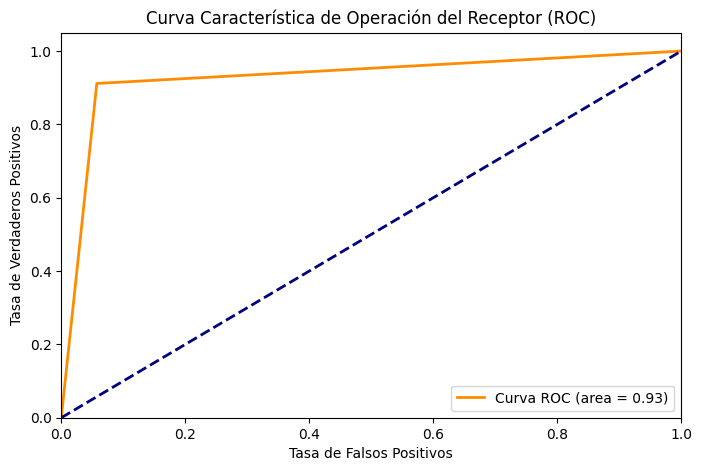

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Asumiendo que tienes y_test como tus etiquetas verdaderas y y_scores como las probabilidades de la clase positiva predichas por tu modelo.
y_pred=pipe_svm.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica de Operación del Receptor (ROC)')
plt.legend(loc="lower right")
plt.show()

In [33]:
from sklearn.metrics import balanced_accuracy_score

y_pred = pipe_svm.predict(X_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print('Balanced accuracy:', balanced_acc)
# Balanced accuracy: 0.7803044930690339

Balanced accuracy: 0.9271309370988446


### Curvas de Aprendizaje

In [34]:
cat_cols=['Pais']
ct = ColumnTransformer([('count', CountVectorizer(), 'Mensaje' ),
                        ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols)]) #drop='first'

pipe_lr = Pipeline([('column_transformer', ct),
                    ('LR', LogisticRegression())])
pipe_dt = Pipeline([('column_transformer', ct),
                    ('DT',DecisionTreeClassifier())])
pipe_rf = Pipeline([('column_transformer', ct),
                    ('RF',RandomForestClassifier())]) 
pipe_knn = Pipeline([('column_transformer', ct),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('column_transformer', ct),
                     ('SVM', svm.SVC())]) 

pipelines = {
    'Logistic Regression': pipe_lr,
    'Decision Tree': pipe_dt,
    'Random Forest': pipe_rf,
    'KNN': pipe_knn,
    'SVM': pipe_svm
}

<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

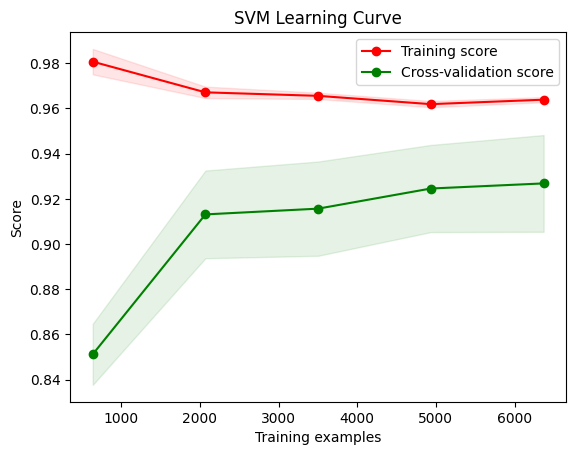

In [35]:
plot_learning_curve(pipe_svm, "SVM Learning Curve", X, y, cv=10)

<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

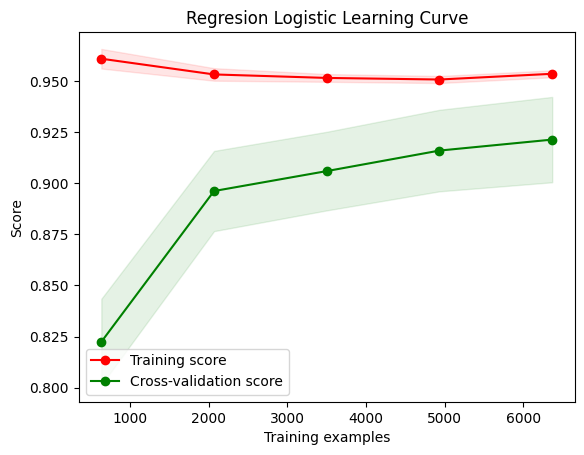

In [36]:
plot_learning_curve(pipe_lr, "Regresion Logistic Learning Curve", X, y, cv=10)

<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

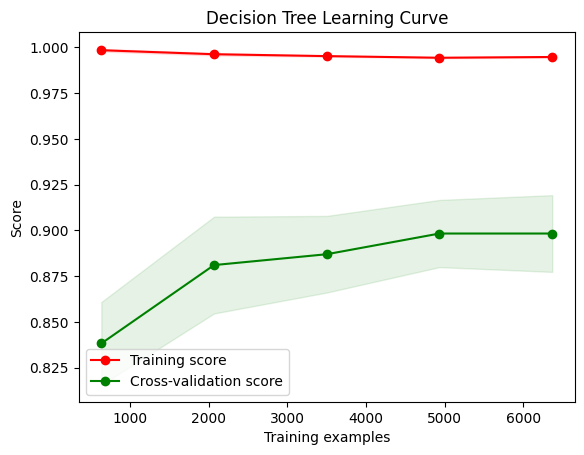

In [37]:
plot_learning_curve(pipe_dt, "Decision Tree Learning Curve", X, y, cv=10)

<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

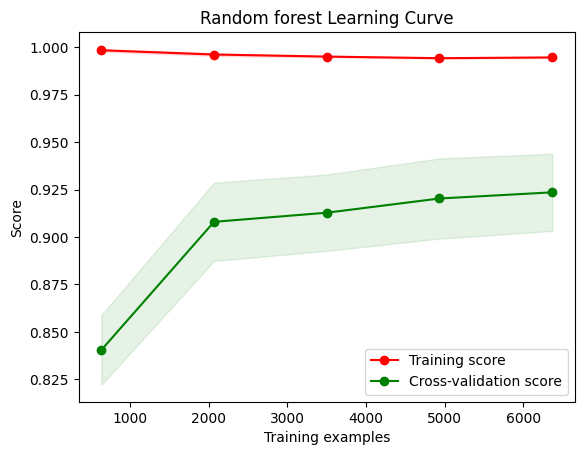

In [38]:
plot_learning_curve(pipe_rf, "Random forest Learning Curve", X, y, cv=10)

<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

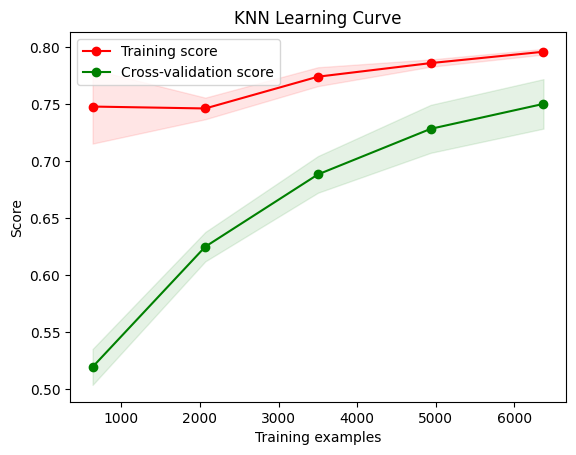

In [39]:
plot_learning_curve(pipe_knn, "KNN Learning Curve", X, y, cv=10)

### Turning Parameter

In [40]:
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]
lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['newton-cg', 'lbfgs', 'liblinear']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]
rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]
knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range}]

In [41]:
lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='recall',
        cv=10)
dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='recall',
        cv=10)
rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='recall',
        cv=10)
knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='recall',
        cv=10)
svm_grid_search = GridSearchCV(estimator=pipe_svm,
        param_grid=svm_param_grid,
        scoring='recall',
        cv=10)

In [42]:
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]
lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['newton-cg', 'lbfgs', 'liblinear']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]
rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]
knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range}]

In [43]:
def perform_grid_search(pipeline, param_grid, name, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='recall',
                               cv=10)
    grid_search.fit(X_train, y_train)
    
    # Obtiene el pipeline con los mejores parámetros encontrados
    best_pipeline = grid_search.best_estimator_
    
    # Muestra la precisión del test y los mejores parámetros
    print(f'{name} Test Precision: {grid_search.score(X_test, y_test):.3f}')
    print(f'{name} Best Params: {grid_search.best_params_}')
    
    # Devuelve el pipeline con el modelo con los mejores hiperparámetros ya establecidos
    return best_pipeline

In [44]:
models_param_grid = {
    'Logistic Regression': (pipe_lr, lr_param_grid),
    'Decision Tree': (pipe_dt, dt_param_grid),
    'Random Forest': (pipe_rf, rf_param_grid),
    'K-Nearest Neighbors': (pipe_knn, knn_param_grid),
    'Support Vector Machines': (pipe_svm, svm_param_grid)
}

# Crear un diccionario para guardar los modelos ajustados
fitted_models = {}

# Ejecutar la búsqueda de cuadrícula para cada modelo y guardar el modelo configurado
for name, (pipeline, param_grid) in models_param_grid.items():
    fitted_models[name] = perform_grid_search(pipeline, param_grid, name, X_train, y_train, X_test, y_test)

Logistic Regression Test Precision: 0.962
Logistic Regression Best Params: {'LR__C': 0.1, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}
Decision Tree Test Precision: 0.981
Decision Tree Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 6, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 4}
Random Forest Test Precision: 0.889
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 3, 'RF__min_samples_split': 2}
K-Nearest Neighbors Test Precision: 0.991
K-Nearest Neighbors Best Params: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5, 'KNN__weights': 'uniform'}
Support Vector Machines Test Precision: 0.948
Support Vector Machines Best Params: {'SVM__C': 5, 'SVM__kernel': 'rbf'}


In [45]:
# configured_dt = fitted_models['Logistic Regression']

In [46]:
fitted_models.keys()

dict_keys(['Logistic Regression', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'Support Vector Machines'])

<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

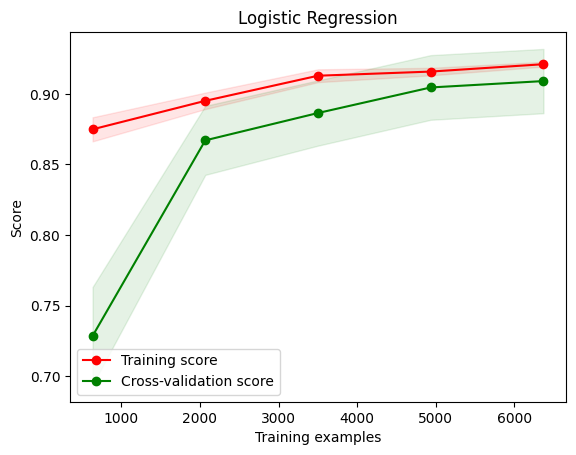

In [47]:
plot_learning_curve(fitted_models['Logistic Regression'], 'Logistic Regression', X, y, cv=10)

<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

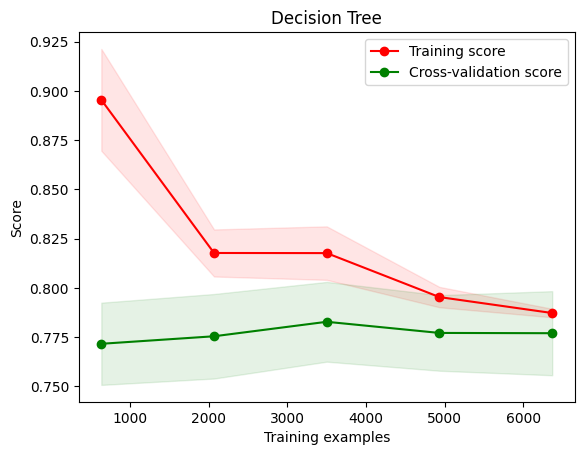

In [48]:
plot_learning_curve(fitted_models['Decision Tree'], 'Decision Tree', X, y, cv=10)

<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

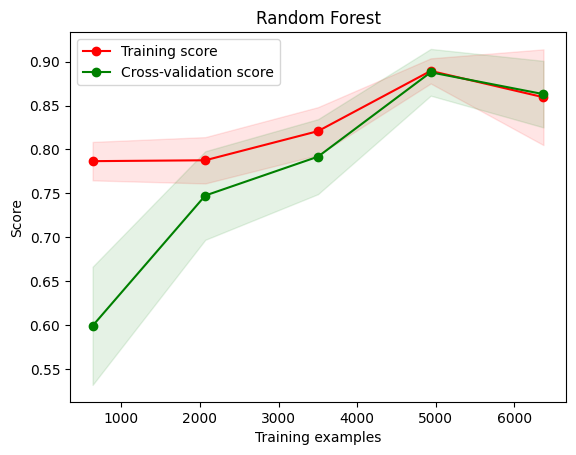

In [49]:
plot_learning_curve(fitted_models['Random Forest'], 'Random Forest', X, y, cv=10)

<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

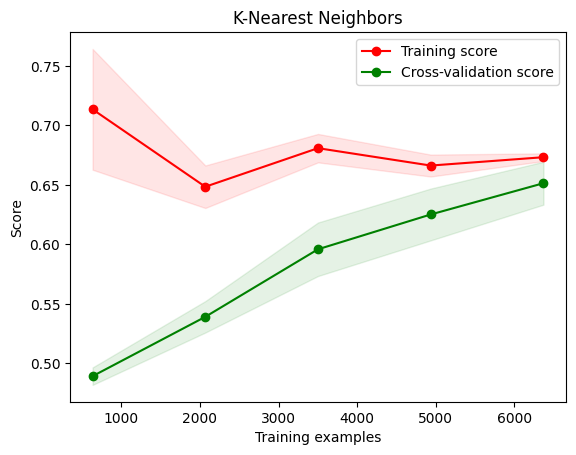

In [50]:
plot_learning_curve(fitted_models['K-Nearest Neighbors'], 'K-Nearest Neighbors', X, y, cv=10)

<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

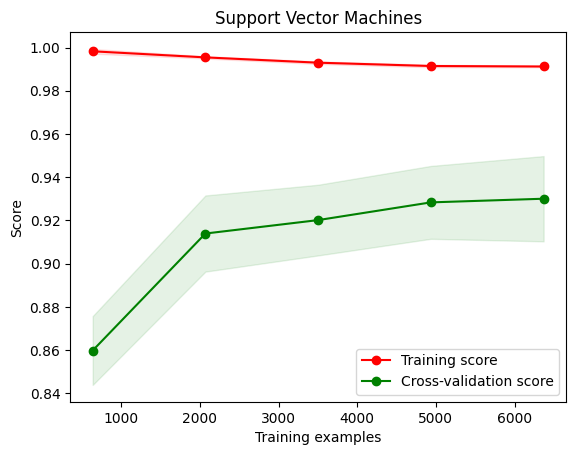

In [51]:
plot_learning_curve(fitted_models['Support Vector Machines'], 'Support Vector Machines', X, y, cv=10)

In [52]:
pipe_lr_l1 = Pipeline([
    ('column_transformer', ct),
    ('LR', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced'))
])

param_range_fl = [1.0, 0.5, 0.1, 0.01, 0.001]
lr_param_grid_l1 = [{
    'LR__C': param_range_fl
}]

# Crear y ajustar la búsqueda en cuadrícula con regularización L1
lr_grid_search_l1 = GridSearchCV(estimator=pipe_lr_l1,
                                 param_grid=lr_param_grid_l1,
                                 scoring='precision',
                                 cv=10)

# Ajustar el modelo con datos de entrenamiento
lr_grid_search_l1.fit(X_train, y_train)

# Mostrar los mejores parámetros y la precisión de prueba del modelo ajustado
print('Logistic Regression (L1) Test Precision: {:.3f}'.format(lr_grid_search_l1.score(X_test, y_test)))
print('Logistic Regression (L1) Best Params:', lr_grid_search_l1.best_params_)

Logistic Regression (L1) Test Precision: 0.979
Logistic Regression (L1) Best Params: {'LR__C': 0.01}


<module 'matplotlib.pyplot' from 'C:\\Users\\fgarcia\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

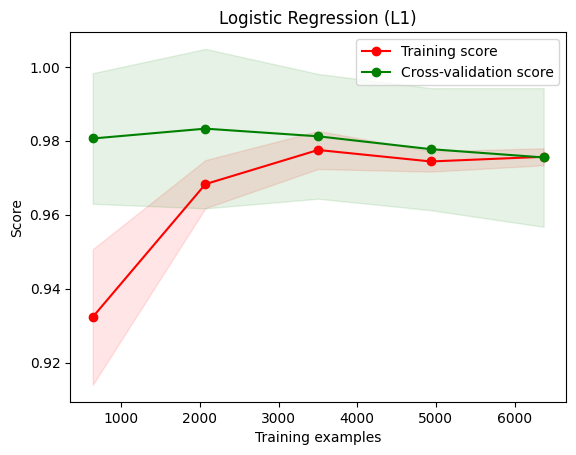

In [53]:
plot_learning_curve(lr_grid_search_l1, 'Logistic Regression (L1)', X, y, cv=10)

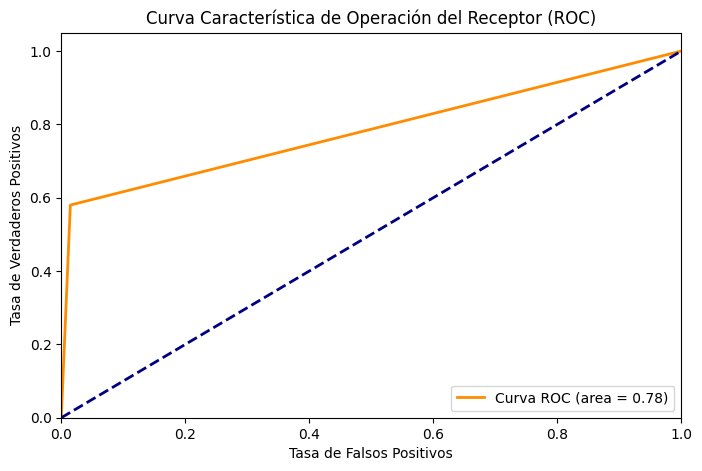

In [57]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Asumiendo que tienes y_test como tus etiquetas verdaderas y y_scores como las probabilidades de la clase positiva predichas por tu modelo.
y_pred=lr_grid_search_l1.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica de Operación del Receptor (ROC)')
plt.legend(loc="lower right")
plt.show()